<font size="7"><b>Text mining</font>

In [2]:
#Cargar librerias
library(NLP)
library(tm)
library(SnowballC)
library(wordcloud)
library(ggplot2)
library(dplyr)
library(readr)
library(cluster)
library(xlsx)
library(data.table)
library(plotly)
library(reshape)
library(rpart.plot)

# data reading

In [3]:
base=fread("../data/Datos.csv", sep=";")#, encoding="UTF-8")
head(base,3)

Doc,Elem_Datos_Cod_Dgn,GrupoDg,EVOL_2015_ANALISIS
6e+19,T913,T9,Paciente con secuelas de TRM con nivel que le permite una funcionalidadaceptable. Los problemas que tiene para las transferencias están más relacionados con el medio en el que se desenvuelve
6e+19,S724,S7,Paciente de 18 meses con hospitalización prolongada con PCI con cuadriparesia espástica trastorno de la motilidad GI severa y multiplescomorbilidades en manejo. Desde hace 3 día con picos febriles
6e+19,S724,S7,leana con episodio de traqueitis vs ineumonia asociada a los cuidados ty ademas hace dos dias fractura supracondilea ya inmovilizaada se le inicio nuevo esquema de antibioticos . se sle solicito calcio y p por la fr


# data cleaning

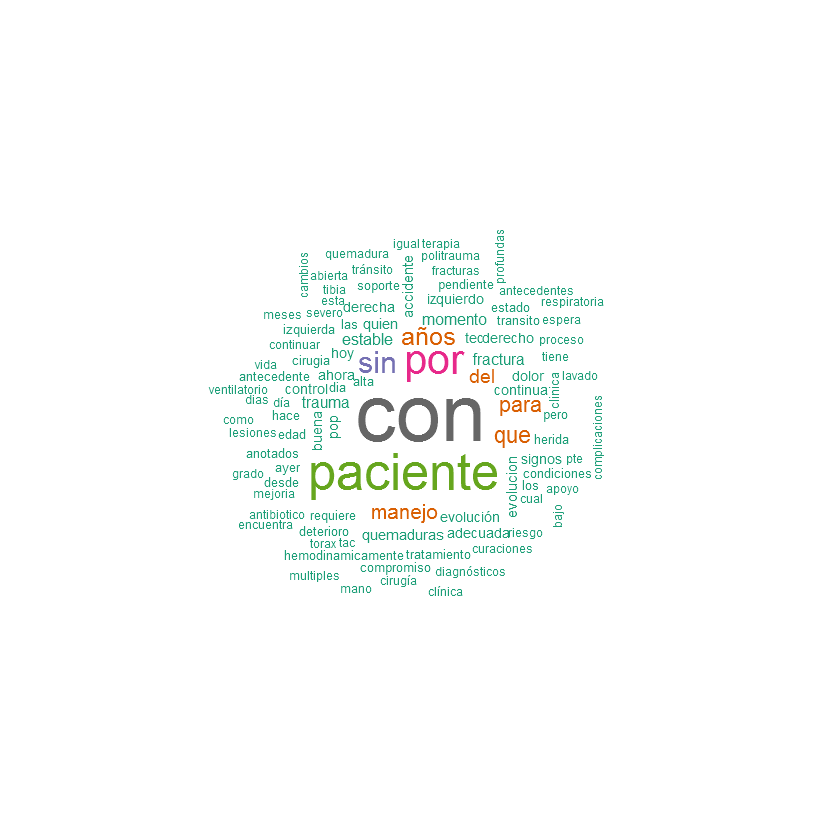

In [13]:
# first cloud
base_text=base
wordcloud(base_text$Descripcion, max.words = 100, random.order = F, colors = brewer.pal(name = "Dark2", n = 8))

In [14]:
#caracteres especiales
base_text$Descripcion <- gsub("[[:cntrl:]]", " ", base_text$Descripcion)

#minusculas
base_text$Descripcion <- tolower(base_text$Descripcion)

#quitar puntuaciÃ³n
base_text$Descripcion <- removePunctuation(base_text$Descripcion)

#Quitar numeros
base_text$Descripcion <- removeNumbers(base_text$Descripcion)

# quitar multiples Espacios 
base_text$Descripcion <- stripWhitespace(base_text$Descripcion)

#eliminar palabras vacias (preposiciones y muletillas)
base_text$Descripcion <- removeWords(base_text$Descripcion, words = stopwords("spanish"))

# quitar palabras que no aportan valor (por criterio experto)
base_text$Descripcion <- removeWords(base_text$Descripcion, words = c("usuario"))

# reemplazar palabras segun diccionario de datos
base_text$Descripcion <- gsub("reinicia", "reiniciar", base_text$Descripcion)

#Tildes
base_text$Descripcion <- gsub("á", "a", base_text$Descripcion)
base_text$Descripcion <- gsub("é", "e", base_text$Descripcion)
base_text$Descripcion <- gsub("í", "i", base_text$Descripcion)
base_text$Descripcion <- gsub("ó", "o", base_text$Descripcion)
base_text$Descripcion <- gsub("ú", "u", base_text$Descripcion)
base_text$Descripcion <- gsub("ñ", "n", base_text$Descripcion)
base_text$Descripcion <- gsub("ü", "u", base_text$Descripcion)

# Corpus

In [123]:
#Corpus 1
base_corpus <- Corpus(VectorSource(base_text$Descripcion))

In [181]:
#corpus 2 sin "genero"
base_corpus_stem <- tm_map(base_corpus, stemDocument, language = "spanish")

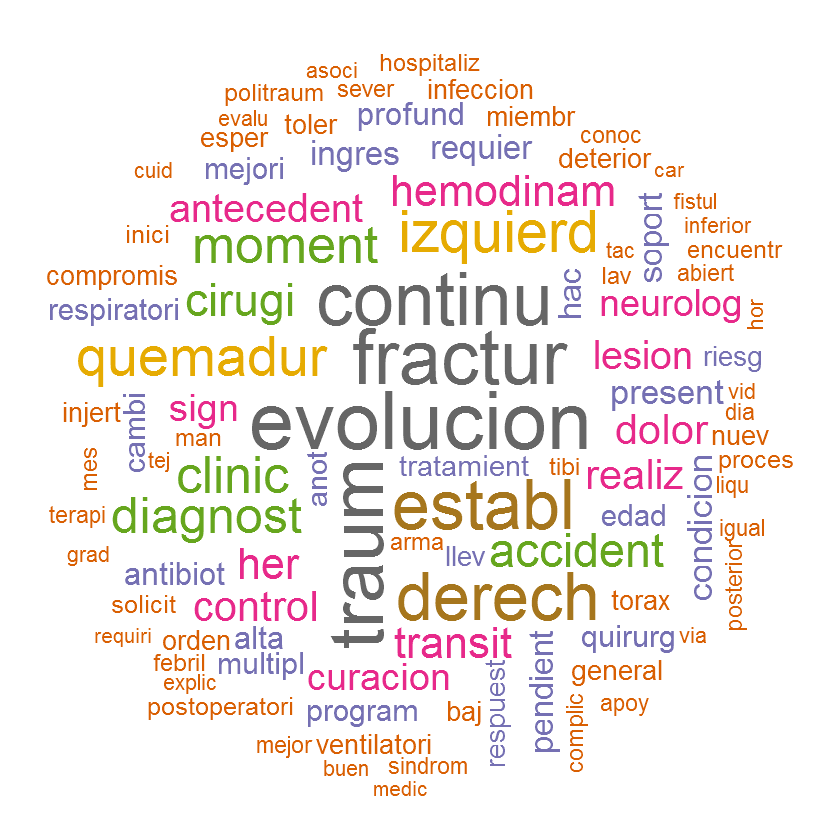

In [182]:
wordcloud(base_corpus_stem, max.words = 100, random.order = F, colors = brewer.pal(name = "Dark2", n = 8))

In [240]:
#Matriz de términos
base_tdm <- TermDocumentMatrix(base_corpus)

In [241]:
#Matriz de términos stem
base_tdm_stem <- TermDocumentMatrix(base_corpus_stem)

In [243]:
#Eliminar términos dispersos
base_new = base_tdm
base_new <- removeSparseTerms(base_tdm, sparse = .965)

In [244]:
#Eliminar términos dispersos con stem
base_new_stem = base_tdm_stem
base_new_stem <- removeSparseTerms(base_tdm_stem, sparse = .965)

In [277]:
dim(base_new)

[1]     32 351627

In [246]:
dim(base_new_stem)

[1]     47 351627

In [247]:
#matriz de términos
base_mat <- as.matrix(base_new)

In [267]:
# con stem
base_mat_stem <- as.matrix(base_new_stem)

# Frecuencia de palabras

In [249]:
# sumas de renglon
base_mat_Freq <- base_mat %>% rowSums() %>% sort(decreasing = TRUE)
base_mat_Freq <- data.frame(palabra = names(base_mat_Freq), frec = base_mat_Freq)

In [250]:
# sumas de renglon con stem
base_mat_Freq_stem <- base_mat_stem %>% rowSums() %>% sort(decreasing = TRUE)
base_mat_Freq_stem <- data.frame(palabra = names(base_mat_Freq_stem), frec = base_mat_Freq_stem)

In [294]:
#Top 10 de palabras comunes 
head(base_mat_Freq,10)

,palabra,frec
evolucion,evolucion,47543
trauma,trauma,45424
estable,estable,38158
fractura,fractura,36102
momento,momento,29791
continua,continua,29375
accidente,accidente,26300
cirugia,cirugia,25333
quemaduras,quemaduras,23358
transito,transito,23286


In [293]:
#Top 10 de palabras comunes 
head(base_mat_Freq_stem,10)

,palabra,frec
evolucion,evolucion,50926
fractur,fractur,47394
traum,traum,46423
continu,continu,45466
establ,establ,42503
derech,derech,40786
izquierd,izquierd,34908
quemadur,quemadur,32128
moment,moment,30376
clinic,clinic,29289


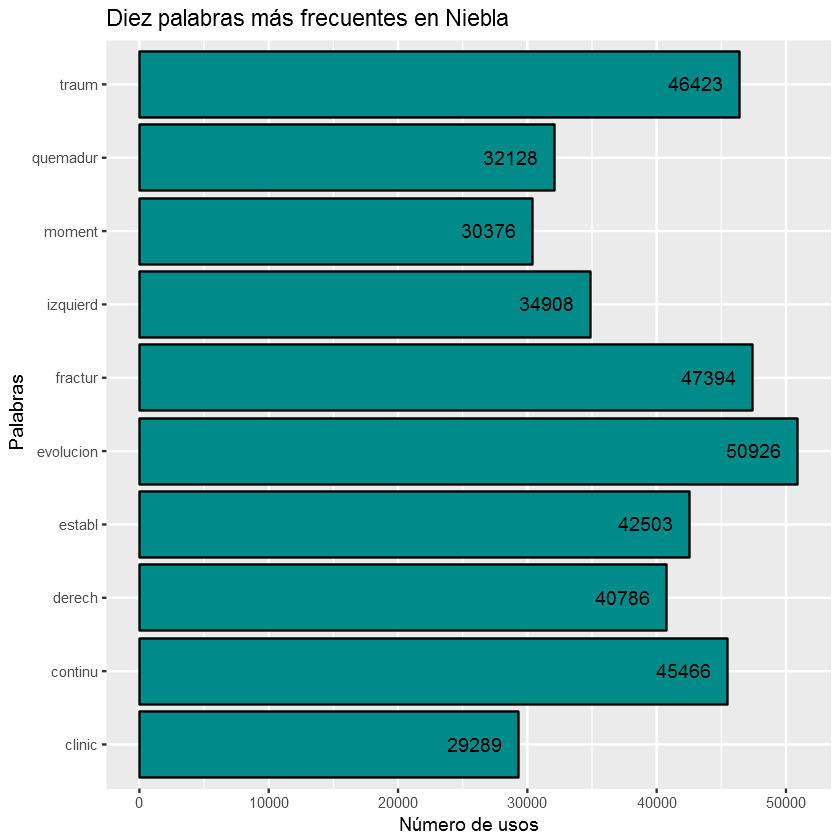

In [226]:
base_mat_Freq[1:10, ] %>%
  ggplot(aes(palabra, frec)) +
  geom_bar(stat = "identity", color = "black", fill = "darkcyan") +
  geom_text(aes(hjust = 1.3, label = frec)) + 
  coord_flip() + 
  labs(title = "Diez palabras más frecuentes en Niebla",  x = "Palabras", y = "Número de usos")

# Cluster K-means

In [263]:
#Estandarizar
base_mat2_stem=scale(base_mat_stem)

In [265]:
dim(base_mat2_stem)

[1]     47 351627

In [351]:
wss <- (nrow(base_mat_stem)-1)*sum(apply(base_mat_stem,2,var))

In [352]:
wss

[1] 1076968

In [345]:
######------------------------------------ Determine numero de clusters
wss <- (nrow(base_mat)-1)*sum(apply(base_mat,2,var))

for (i in 2:10) wss[i] <- sum(kmeans(base_mat,centers=i)$withinss)


In [347]:
######------------------------------------ Determine numero de clusters
wss <- (nrow(base_mat2_stem)-1)*sum(apply(base_mat2_stem,2,var))

for (i in 2:5) wss[i] <- sum(kmeans(base_mat2_stem, centers=i)$withinss)

ERROR: Error in do_one(nmeth): NA/NaN/Inf en llamada a una función externa (arg 1)


In [ ]:
plot(1:10, wss[2:10], type="b", xlab="Number of Clusters",
  ylab="Within groups sum of squares", main="Clusters) Sum_Cuad")

In [348]:
dim(base_mat)
dim(base_mat_stem)

[1]     32 351627

[1]     47 351627

In [173]:

######---------------------------------- K-Means Cluster Analysis
fit <- kmeans(base_mat, 7) # 3 cluster solution
# get cluster means 
#aggregate(base_mat,by=list(fit$cluster),FUN=mean)
# append cluster assignment
DatosKmeans <- data.frame(base_mat, fit$cluster)


In [174]:
table(DatosKmeans$fit.cluster)


  1   2   3   4   5   6   7 
  3   4   1   3   1  18 195 

In [164]:
DatosKmeans[DatosKmeans$fit.cluster==6,]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X351619,X351620,X351621,X351622,X351623,X351624,X351625,X351626,X351627,fit.cluster
signos,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6
derecho,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
clinica,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
derecha,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
dolor,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,6
cirugia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
control,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
herida,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
alta,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
torax,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


# Cluster Jerárquico aglomerativo

In [236]:
#Estandarizar
base_mat2=scale(base_mat)

In [237]:
#Distancias
base_dist <- dist(base_new, method = "euclidian")

In [238]:
# Cluster jerarquico aglomerativo
base_hclust <-  hclust(base_dist, method = "ward.D")

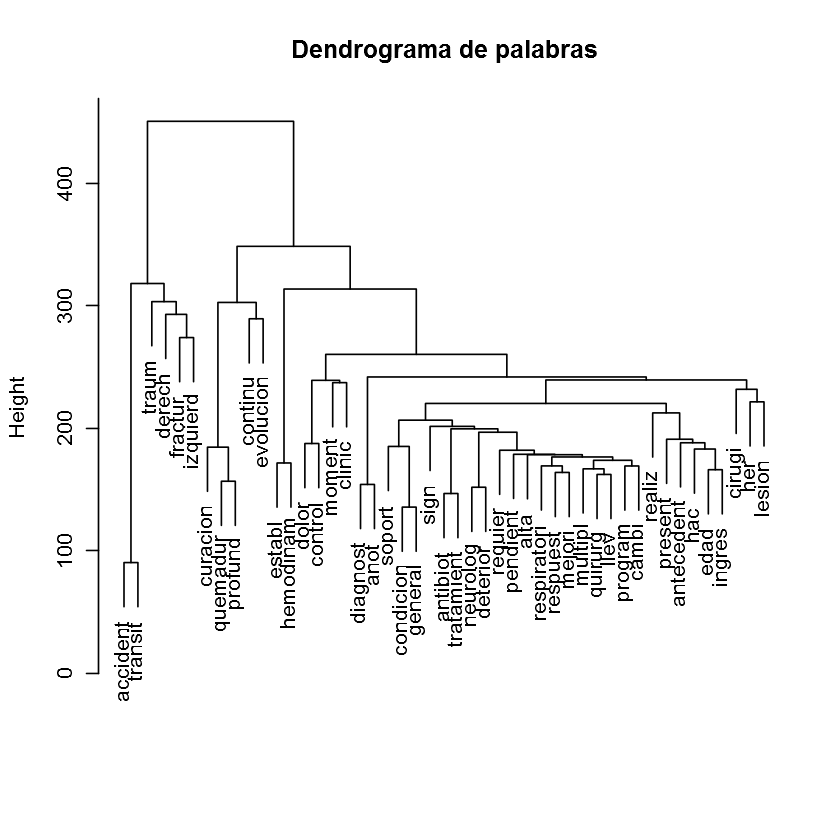

In [239]:
plot(base_hclust, main = "Dendrograma de palabras", sub = "", xlab = "")

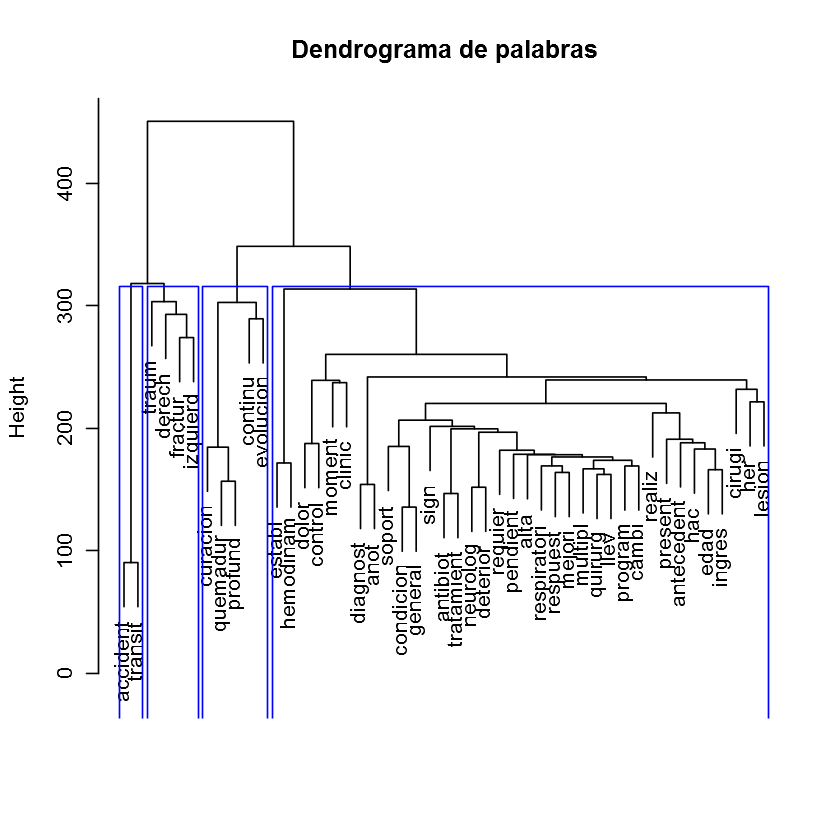

In [257]:
plot(base_hclust, main = "Dendrograma de palabras", sub = "", xlab = "")
rect.hclust(base_hclust, k = 4, border="blue")

# Asociaciones opcion 1

In [288]:
?findAssocs

In [291]:
findAssocs(base_new_stem,  terms = c("evolucion","fractur","traum","continu","establ","derech","izquierd","quemadur","clinic","diagnost","accident","cirugi","hemodinam","transit","control","dolor","antecedent"), corlimit = .05)

$evolucion
curacion     sign   mejori  profund respuest antibiot neurolog    cambi 
    0.12     0.10     0.10     0.09     0.08     0.06     0.05     0.05 

$fractur
 multipl  quirurg pendient 
    0.10     0.09     0.06 

$traum
neurolog  multipl   lesion  quirurg     alta 
    0.08     0.07     0.07     0.07     0.05 

$continu
   curacion respiratori      soport   condicion     general    antibiot 
       0.13        0.12        0.12        0.11        0.08        0.07 
   deterior 
       0.07 

$establ
   deterior      moment   condicion    neurolog respiratori        sign 
       0.17        0.16        0.16        0.11        0.10        0.10 
    general    respuest    pendient      soport       cambi    curacion 
       0.09        0.08        0.08        0.08        0.07        0.05 

$derech
   her lesion 
  0.10   0.06 

$izquierd
   her lesion 
  0.08   0.07 

$quemadur
 profund curacion     sign 
    0.57     0.37     0.06 

$clinic
     sign    mejori  deterior  respuest   profund      anot    moment  antibiot 
     0.13      0.11      0.11      0.09      0.07      0.06      0.06      0.05 
condicion 
     0.05 

$diagnost
anot 
0.45 

$accident
numeric(0)

$cirugi
    llev  program  general pendient  requier 
    0.28     0.22     0.10     0.09     0.07 

$hemodinam
respiratori    deterior      soport   condicion     general    respuest 
       0.15        0.15        0.14        0.13        0.11        0.09 
     moment    neurolog        sign        anot 
       0.09        0.08        0.08        0.06 

$transit
numeric(0)

$control
numeric(0)

$dolor
moment   sign 
  0.07   0.06 

$antecedent
   edad  ingres     hac    anot multipl 
   0.13    0.10    0.07    0.07    0.05

# Asociaciones Opcion2

In [303]:
.libPaths()

[1] "C:/Users/acastano/AppData/Local/Continuum/Anaconda3/R/library"

In [305]:
library(Matrix)
library(arules)

In [306]:
data("Adult")

In [328]:
head(base_mat_stem)

,1,2,3,4,5,6,7,8,9,10,...,351618,351619,351620,351621,351622,351623,351624,351625,351626,351627
traum,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hac,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
antibiot,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fractur,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
present,0,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
diagnost,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [336]:
#base_mat_stem_associacion = base_mat_stem>=1
base_mat_stem_associacion=ifelse(base_mat_stem>=1,1,0)


In [337]:
head(base_mat_stem_associacion)

,1,2,3,4,5,6,7,8,9,10,...,351618,351619,351620,351621,351622,351623,351624,351625,351626,351627
traum,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hac,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
antibiot,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fractur,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
present,0,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
diagnost,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [341]:
dim(base_mat_stem_associacion)

[1]     47 351627

In [342]:
## Mine association rules.
rules <- apriori(base_mat_stem_associacion, parameter = list(supp = 0.01, conf = 0.01, target = "rules"))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.01    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 0 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[301633 item(s), 47 transaction(s)] done [0.45s].
sorting and recoding items ... [301633 item(s)] done [0.12s].
creating transaction tree ... done [0.01s].
checking subsets of size 1

ERROR: Error in apriori(base_mat_stem_associacion, parameter = list(supp = 0.01, : not enough memory. Increase minimum support!



In [343]:
summary(rules)

set of 0 rules


In [344]:
inspect(head(rules))

ERROR: Error in slot(x, s)[i]: subscript out of bounds
